In [1]:
import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook 
%matplotlib notebook 

plt.rcParams.update({'font.size': 14})

dataPath = ".\Pilot20220325LeakOil"

In [6]:
'''
General function
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (12,4))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax

# The default decoding format is one float number
def decodeTrackData(dataFormat, dataStr, numFormat = "\d+\.\d+", numNum = 1):
    findResult = re.findall(dataFormat, aLine)
    
    findData = []
    
    if findResult:
        findNums = re.findall(numFormat, findResult[0])
        if(len(findNums) != numNum):
            print("Incorrectly find %d %s given %d in command" % (len(findNums), numFormat, numNum))
            return findData
        else:
            for num in findNums:
                try:
                    num = float(num)
                except:
                    pass               
                findData.append(num)

    else: # Padding None if no number is found
        findData = [None] * numNum
        
    return findData

def decodeTaskSummary(taskFormat, completeStatusFormat, completeTimeFormat, dataStr):
    findData = []
    
    taskSummaries = re.findall(taskFormat+completeStatusFormat+completeTimeFormat, dataStr)
    
    for taskSummary in taskSummaries:
        res = re.findall(taskFormat+"|"+completeStatusFormat+"|"+completeTimeFormat, taskSummary)
        try:
            res[2] = float(res[2])
        except:
            pass   
        findData.append(res)
    
    return findData
    

In [7]:
'''
Data format
'''

vrDataInfo = [] # dataStamp, trialNum, voltageLevel, startTime, score
vrDataTrack = {} # time (secs), indexX, indexY, indexZ, thumbX, thumbY, thumbZ, indexDist, thumbDist, object
vrDataSummary = {} # object, taskResult, competeTime (secs)

for root, directories, files in walk(dataPath):
    for fileName in files:
        if(re.search('\.txt', fileName)):
            condi = re.split('_|\.txt', fileName)
            dataStamp = condi[0]
            trialNum = int(re.findall("\d+", condi[-2])[0])

            file1 = open(ospa.join(root, fileName), 'r')
            fileLines = file1.readlines()
            
            dataTrack = [] # time (secs), indexX, indexY, indexZ, thumbX, thumbY, thumbZ, indexDist, thumbDist, object
            voltageLevel = None # voltageLevel, 
            startTime = None # startTime (Universal Time)
            dataSummary = [] # object, taskResult, competeTime (secs)
            score = None # Final score               
            
            for aLine in fileLines:
                if(aLine[0] == 't'):  
                    aTrackFrame = []
                    
                    # time (secs)
                    aTrackFrame.extend(decodeTrackData("t\d+\.\d+", aLine))
                    
                    # (indexX, indexY, indexZ)
                    aTrackFrame.extend(decodeTrackData("in\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
            
                    # (thumbX, thumbY, thumbZ)
                    aTrackFrame.extend(decodeTrackData("th\(\d+\.\d+, \d+\.\d+, \d+\.\d+\)", aLine, "\d+\.\d+", 3))
                    
                    # indexDist
                    aTrackFrame.extend(decodeTrackData("indi\d+\.\d+", aLine))
                    
                    # thumbDist
                    aTrackFrame.extend(decodeTrackData("thdi\d+\.\d+", aLine))
                    
                    # object (Name)
                    aTrackFrame.extend(decodeTrackData("Grape\d+ | Key\d+", aLine, "Grape\d+ | Key\d+"))
             
                    dataTrack.append(aTrackFrame)
                
                elif(aLine[0] == 'v'):
                    voltageLevel = decodeTrackData("voltLevel\d+", aLine, "\d+")
                    
                    startTime = decodeTrackData("starttimestamp\d+", aLine, "\d+")
                    
                    completeInfo = re.findall("completeinfo.*", aLine)[0]
                    
                    dataSummary = []
                    dataSummary.extend(decodeTaskSummary("Grape\d+", "[a-zA-Z]+", "\d+\.\d+", completeInfo))
                    dataSummary.extend(decodeTaskSummary("A\d+E\d+", "[a-zA-Z]+", "\d+\.\d+", completeInfo))
                    
                    score = decodeTrackData("score\d+", completeInfo, "\d+")
            
            print(dataStamp)
            
            vrDataTrack[dataStamp] = pd.DataFrame(dataTrack, columns = ['Time', 'IndexX', 'IndexY', 'IndexZ', 
                                                           'ThumbX', 'ThumbY', 'ThumbZ', 
                                                           'IndexDist', 'ThumbDist', 'Object'])
            
            vrDataSummary[dataStamp] = pd.DataFrame(dataSummary, columns = ['Object', 'TaskResult', 'CompeteTime'])
            
            vrDataInfo.append([dataStamp, trialNum, voltageLevel, startTime, score])
            
vrDataInfo = pd.DataFrame(vrDataInfo, columns = ['Label', 'Trial', 'VoltLevel', 'StartTime', 'Score'])        
vrDataInfo.head()

Data15-13-58
Data16-44-22
Data17-18-55
Data17-21-30


Label  Trial VoltLevel StartTime  Score
0  Data15-13-58      0   [100.0]    [68.0]  [2.0]
1  Data16-44-22      1   [100.0]   [140.0]  [3.0]
2  Data17-18-55      0   [100.0]    [65.0]  [3.0]
3  Data17-21-30      1   [100.0]   [187.0]  [4.0]

In [8]:
vrDataTrack[dataStamp].head()

Time  IndexX  IndexY  IndexZ  ThumbX  ThumbY  ThumbZ  IndexDist  \
0  187.707  1.6027  1.1232  1.2760  1.6138  1.1409  1.2445     0.5624   
1  187.721  1.6028  1.1240  1.2760  1.6138  1.1413  1.2446     0.5616   
2  187.735  1.6029  1.1249  1.2761  1.6137  1.1417  1.2447     0.5609   
3  187.748  1.6026  1.1252  1.2761  1.6135  1.1424  1.2450     0.5605   
4  187.763  1.6023  1.1256  1.2761  1.6133  1.1432  1.2452     0.5601   

   ThumbDist Object  
0     0.5613   None  
1     0.5609   None  
2     0.5605   None  
3     0.5597   None  
4     0.5589   None

<IPython.core.display.Javascript object>


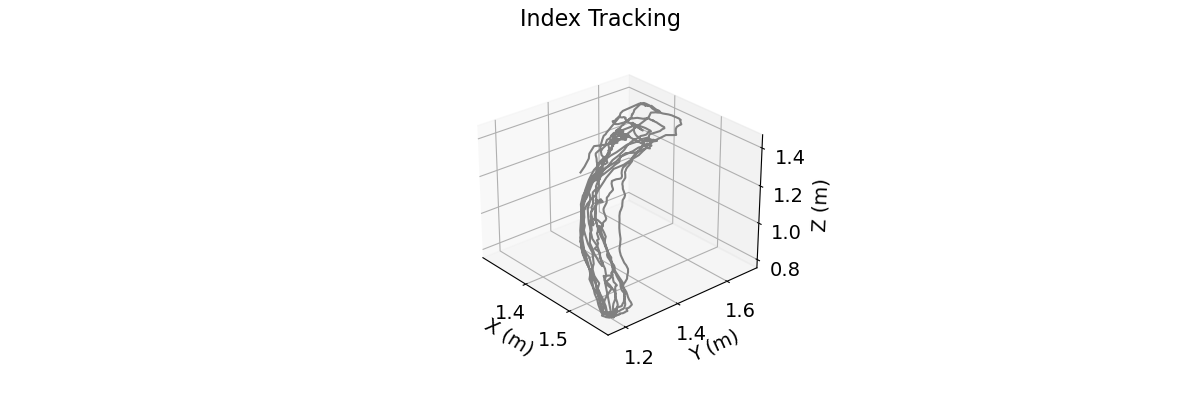

In [9]:
'''
Plot Tracking data
'''

selectLabel = 'Data17-18-55'

trackingData = vrDataTrack[selectLabel]
trackingData.head()

ax = aPlot("Index Tracking", True)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.plot3D(trackingData['IndexX'], trackingData['IndexY'], trackingData['IndexZ'], 'gray')